# exp042
w2v追加

In [22]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal

# 設定

In [23]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "exp042"
    seed = 42
    k = 20
    cand_n = 15
    negative_sample = 1
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week4"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [24]:
class Cache:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        self.cache_dir = (os.path.join(cfg.output_dir, cfg.exp_name, "cache"))
        self.cache_dir_path = pathlib.Path(self.cache_dir)
        self.caches = list(self.cache_dir_path.glob("*.pkl"))

    @noglobal(excepts=["cfg", "logger"])
    def get_abspath(self, filename):
        return (os.path.join(self.cache_dir, filename))
    
    @noglobal(excepts=["cfg", "logger"])
    def exists(self, path):
        return len([str(c) for c in self.caches if path == str(c)]) > 0


cache = Cache()

In [25]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [26]:
@noglobal(excepts=["cfg", "logger"])
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.60
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [27]:
class Candidate:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, pdf, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid"], dtype=int)
        self.labels = labels
    
    @noglobal(excepts=["cfg", "logger"])
    def _entry(self, new_candidate_df, name, k):
        logger.info(f"[add_candidate] {name} : start")
        new_candidate_df[f"{name}_rank"] = new_candidate_df.groupby("session")["session"].cumcount()
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df[["session", "aid"]]])
        self.output = self.output.drop_duplicates(subset=["session", "aid"])
        
        self.output = self.output.merge(new_candidate_df, on=["session", "aid"], how="left")

        if self.labels is not None:
            self._eval(new_candidate_df[["session", "aid"]], name, k)
    
    @noglobal(excepts=["cfg", "logger"])
    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        
        print(eval_result)
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    @noglobal(excepts=["cfg", "logger"])
    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        logger.info(f"[make_candidate] {name} : start")
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map)
            candidate_df = candidate_df.dropna(subset=["aid"])
            
        self._entry(candidate_df, name, k)

    @noglobal(excepts=["cfg", "logger"])
    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [28]:
@noglobal(excepts=["cfg", "logger"])
def add_labels(df, labels, type_):
    type_labels = labels[["session", f"{type_}_labels"]].dropna().copy()
    type_labels.columns = ["session", "aid"]
    type_labels = type_labels.explode("aid")
    type_labels["labels"] = 1
    df = df.merge(type_labels, on=["session", "aid"], how="left")
    df["labels"] = df["labels"].fillna(0)
    return df    

In [29]:
@noglobal(excepts=["cfg", "logger"])
def add_ground_truth_candidate(df, labels, type_):
    gt = labels[["session", f"{type_}_labels"]].dropna().copy()
    gt.columns = ["session", "aid"]
    gt = gt.explode("aid")
    df = pd.concat([df, gt])
    df = df.drop_duplicates()
    return df

In [30]:
@noglobal(excepts=["cfg", "logger"])
def under_sampling(df, label_col):
    cfg = Cfg()
    pos_df = df[df[label_col]==1].copy()
    neg_df = df[df[label_col]==0].copy()
    pos_n = len(pos_df)
    return pd.concat([pos_df, neg_df.sample(pos_n * cfg.negative_sample, random_state=cfg.seed)])

In [31]:
class Features:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, sessions, candidate, week):
        self.sessions = cudf.from_pandas(sessions)
        self.output = candidate
        self.type_dict = cfg.type2id
        self.week = week

    @noglobal(excepts=["cfg", "logger"])
    def add_features(self):
            self._prep()
            self._session_cnt()
            self._session_aid_nunique()
            self._session_last_type()
            # self._session_last_dt()
            self._aid_cnt()
            self._all_times_aid_features()
            self._w2v_vectors()
            # self._session_mean_ts()
            # self._aid_mean_ts()
            # self._aid_cnt_ratio_at_session_last()
            # self.output = self.output.drop(columns=["session_last_day"]) # 日時はtrainセット内のみで有効なので削除

    @noglobal(excepts=["cfg", "logger"])
    def _prep(self):
        logger.info("[features] prep : start")
        # ts関連の前処理
        self.sessions["relative_ts"] = self.sessions["ts"] - self.sessions["ts"].min()
        self.sessions["dt"] = cudf.to_datetime(self.sessions["ts"], unit="ms")
        self.sessions["hour"] = self.sessions["dt"].dt.hour
        self.sessions["week"] = self.sessions["dt"].dt.dayofweek
        self.sessions["day"] = self.sessions["dt"].dt.day
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_cnt(self):
        logger.info("[features] session_cnt : start")
        agg_df = self.sessions.groupby(["session", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})
        # session_total_cnt
        features = agg_df.groupby("session")["cnt"].sum().reset_index().rename(columns={"cnt": "session_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_total_cnt"] = self.output["session_total_cnt"].fillna(0)
        # session_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"session_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_aid_nunique(self):
        logger.info("[features] session_aid_nunique : start")
        features = self.sessions.groupby("session")["aid"].nunique().reset_index().rename(columns={"aid": "session_aid_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_aid_nunique"] = self.output["session_aid_nunique"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_type(self):
        logger.info("[features] session_last_type : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "type"]]
        features = features.rename(columns={"type": "session_last_type"})
        features["session_last_type"] = features["session_last_type"].map(self.type_dict)
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_dt(self):
        logger.info("[features] session_last_dt : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "relative_ts", "week", "day", "hour"]]
        features.columns = ["session", "session_last_ts", "session_last_week", "session_last_day", "session_last_hour"]
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_mean_ts(self):
        logger.info("[features] session_mean_ts : start")
        features = self.sessions.groupby("session")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "session_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_mean_ts(self):
        logger.info("[features] aid_mean_ts : start")
        features = self.sessions.groupby("aid")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "aid_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")
       
    @noglobal(excepts=["cfg", "logger"])
    def _aid_session_nunique(self):
        logger.info("[features] aid_session_unique : start")
        features = self.sessions.groupby("aid")["session"].nunique().reset_index().rename(columns={"session": "aid_session_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")

    @noglobal(excepts=["cfg", "logger"]) 
    def _aid_cnt_ratio_at_session_last(self):
        logger.info("[features] aid_cnt_ratio_atsession_last : start")
        for dt_ in ["week", "day", "hour"]:
            features = self.sessions[["aid", dt_]].copy()
            features["total_cnt"] = features.groupby(dt_)["aid"].transform("count")
            features = features.groupby(["aid", dt_])["total_cnt"].agg(["count", "max"]).reset_index()
            features[f"aid_cnt_ratio_at_session_last_{dt_}"] = features["count"] / features["max"]
            features = features.rename(columns={dt_: f"session_last_{dt_}"})
            self.output = self.output.merge(features[["aid", f"session_last_{dt_}", f"aid_cnt_ratio_at_session_last_{dt_}"]].to_pandas(), on=["aid", f"session_last_{dt_}"], how="left")
            self.output[f"aid_cnt_ratio_at_session_last_{dt_}"] = self.output[f"aid_cnt_ratio_at_session_last_{dt_}"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_cnt(self):
        logger.info("[features] aid_cnt : start")
        agg_df = self.sessions.groupby(["session", "aid", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})

        # aid_total_cnt
        features = agg_df.groupby(["session", "aid"])["cnt"].sum().reset_index().rename(columns={"cnt": "aid_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
        self.output["aid_total_cnt"] = self.output["aid_total_cnt"].fillna(0)

        # aid_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"aid_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", "aid", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)

    @noglobal(excepts=["cfg", "logger"])
    def _all_times_aid_features(self):
        feats = ["all_times_aid_freq",
                 "all_times_aid_clicks_freq",
                 "all_times_aid_carts_freq",
                 "all_times_aid_orders_freq",
                 "all_times_aid_session_freq",
                 "all_times_aid_session_clicks_freq",
                 "all_times_aid_session_carts_freq",
                 "all_times_aid_session_orders_freq",
                 "all_times_aid_carts_ratio_with_clicks",
                 "all_times_aid_orders_ratio_with_clicks",
                 "all_times_aid_date_std",
                 "all_times_aid_hour_std",
                 "all_times_aid_day_of_week_std"]

    @noglobal(excepts=["cfg", "logger"])
    def _w2v_vectors(self):
        w2v_vecs = pd.read_pickle(cfg.prep_dir + "w2v_vector_n5.pkl")
        self.output = self.output.merge(w2v_vecs, on="aid", how="left")


In [32]:
@noglobal(excepts=["cfg", "logger"])
def add_features(sessions, cand_df, week=None):
    feat = Features(sessions, cand_df, week)
    feat.add_features()
    return feat.output

In [33]:
@noglobal(excepts=["cfg", "logger"])
def make_cand_df(sessions, labels=None, trans_maps=None):

    if labels is not None:
         cand = Candidate(sessions, labels)
    else:
        cand = Candidate(sessions)

    cand.add(strategy="session_frequent", name="session_frequent", k=cfg.cand_n)
    cand.add(strategy="session_latest", name="session_latest", k=cfg.cand_n)
    # cand.add(strategy="total_frequent", name="total_frequent", k=cfg.cand_n)
    cand.add(strategy="session_frequent", trans_map=trans_maps["pair0"], name="session_frequent_pair", k=cfg.cand_n)
    
    for i in range(10):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}", k=cfg.cand_n)
    
    for i in range(10):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"time_wt_pair{str(i)}"], name=f"session_latest_time_wt_pair{str(i)}", k=cfg.cand_n)
    
    cand.add(strategy="session_latest", trans_map=trans_maps["type_wt_pair"], name="session_latest_type_wt_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks2carts_pair"], name="session_latest_clicks2carts_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks2orders_pair"], name="session_latest_clicks2orders_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["w2v_sim_pair"], name="session_latest_w2v_sim_pair", k=cfg.cand_n)
    if labels is not None:
        return cand.output, cand.results
    else:
        return cand.output

In [34]:
@noglobal(excepts=["cfg", "logger"])
def get_pair_df(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    pair_df = pd.read_pickle(cfg.prep_dir + f"{name}.pkl")
    pair_df = pair_df.sort_values(["aid_x", wt_col], ascending=(True, False))
    return pair_df

@noglobal(excepts=["cfg", "logger"])
def get_pair_dict(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    pair_df = pd.read_pickle(cfg.prep_dir + f"{name}.pkl")
    pair_df = pair_df.sort_values(["aid_x", wt_col], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    return pair_dict

@noglobal(excepts=["cfg", "logger"])
def get_trans_maps(week=None):
    """
    aidを別のaidに置き換えるmapping辞書を取得する
    """
    trans_maps = {}
    
    pair_df_org = get_pair_df("co_visitation_matrix", "cnt", week)
    for i in range(10):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"pair{str(i)}"] = pair_dict
    
    pair_df_org = get_pair_df("co_visitation_matrix_time_weighted", "wt", week)
    for i in range(10):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"time_wt_pair{str(i)}"] = pair_dict
    
    trans_maps["clicks_pair"] = get_pair_dict("co_visitation_matrix_clicks", "cnt", week)
    trans_maps["carts_pair"] = get_pair_dict("co_visitation_matrix_carts", "cnt", week)
    trans_maps["orders_pair"] = get_pair_dict("co_visitation_matrix_orders", "cnt", week)
    trans_maps["type_wt_pair"] = get_pair_dict("co_visitation_matrix_type_weighted", "wt", week)
    trans_maps["clicks2carts_pair"] = get_pair_dict("co_visitation_matrix_clicks2carts", "cnt", week)
    trans_maps["clicks2orders_pair"] = get_pair_dict("co_visitation_matrix_clicks2orders", "cnt", week)
    trans_maps["w2v_sim_pair"] = get_pair_dict("word2vec_similar", "sim", None)

    return trans_maps


In [35]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_train_data(type_):
    dfs = []
    for weeks in cfg.train_weeks:
        # データ読み込み
        week_sessions = pd.read_pickle(cfg.prep_dir + f"train_sessions_{weeks}.pkl")
        week_labels = pd.read_pickle(cfg.prep_dir + f"labels_{weeks}.pkl")
        
        cache_file = f"train_cand_{weeks}.pkl"
        cache_path = cache.get_abspath(cache_file)
        print(cache_path)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            cand_df = pd.read_pickle(cache_path)
        else:
            trans_map_cache_file = f"trans_maps_{weeks}.pkl"
            trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
            with open(trans_map_cache_path, "rb") as f:
                trans_maps = pickle.load(f)
            # 候補選出
            cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
            cand_df = reduce_mem_usage(cand_df)
            cand_df.to_pickle(cache_path)

        cand_df = add_labels(cand_df, week_labels, type_)
        cand_df = under_sampling(cand_df, "labels")

        # 特徴量付与
        train_tmp = add_features(week_sessions, cand_df, weeks)
        dfs.append(train_tmp)
        del cand_df, train_tmp
        gc.collect()
        
    train = pd.concat(dfs)
    train = train.reset_index(drop=True)
    train = reduce_mem_usage(train)
    
    return train

In [36]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_valid_cand():
    valid_week = cfg.valid_week
    # データ読み込み
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
    valid_session_ids = week_sessions["session"].unique().tolist()
    trans_map_cache_file = f"trans_maps_{valid_week}.pkl"
    trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
    with open(trans_map_cache_path, "rb") as f:
        trans_maps = pickle.load(f)

    # validに使うsessionを絞る
    valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
    random.seed(cfg.seed)
    valid_session_ids = random.sample(valid_session_ids, valid_session_n)
    week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
    week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()

    # 候補選出
    cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
    cand_df = reduce_mem_usage(cand_df)
    return cand_df, week_sessions, week_labels

In [37]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_data(cand_df, week_sessions, week_labels, type_):
    # 特徴量付与
    valid = add_features(week_sessions, cand_df, cfg.valid_week)
    valid = add_labels(valid, week_labels, type_)
    valid = valid.reset_index(drop=True)
    valid = reduce_mem_usage(valid)
    return valid

In [38]:
@noglobal(excepts=["cfg", "logger"])
def model_training(train, valid, features, target, valid_labels, type_):
    params = {'objective': 'binary', 
            'boosting': 'gbdt', 
            'learning_rate': 0.1, 
            'metric': 'binary_logloss', 
            'seed': cfg.seed
            }

    # 学習
    vl_pred_df = valid[["session", "aid"]].copy()

    tr_x, tr_y = train[features], train[target]
    vl_x, vl_y = valid[features], valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)

    # 特徴量重要度
    fi = pd.DataFrame()
    fi["feature"] = model.feature_name()
    fi["importance"] = model.feature_importance(importance_type="gain")

    # 2値分類の出力を元にk個選定
    vl_pred_df["prob"] = model.predict(vl_x, num_iteration=model.best_iteration)
    vl_pred_df = vl_pred_df.sort_values(["session", "prob"], ascending=(True, False))
    vl_pred_df = vl_pred_df.groupby(["session"]).head(cfg.k)
    vl_pred_df = vl_pred_df.groupby(["session"])["aid"].apply(list).reset_index()
    
    # 評価
    assert valid_labels["session"].tolist() == vl_pred_df["session"].unique().tolist()
    score = evaluate(valid_labels["clicks_labels"].tolist(),
                     valid_labels["carts_labels"].tolist(),
                     valid_labels["orders_labels"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     cfg.k)
    logger.info(f"{type_} valid score")
    logger.info(score)

    # モデル保存
    model.save_model(cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")

    # 特徴量重要度
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance({type_})")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance_{type_}.png')

    return score[f"recall_{type_}"]

In [39]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_test_data():
    # testデータ作成
    test_sessions = pd.read_pickle(cfg.prep_dir + f"test_sessions.pkl")
    trans_map_cache_file = f"trans_maps.pkl"
    trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
    with open(trans_map_cache_path, "rb") as f:
        trans_maps = pickle.load(f)

    dfs =[]
    # 候補選出
    logger.info("[make_test] make_cand_df")
    cand_df = make_cand_df(test_sessions, trans_maps=trans_maps)
    cand_df = reduce_mem_usage(cand_df)
    # 特徴量付与
    logger.info("[make_test] add_features")
    test = add_features(test_sessions, cand_df)
    test = reduce_mem_usage(test)

    return test

In [40]:
@noglobal(excepts=["cfg", "logger"])
def inference(test, features):
    pred_dfs = []
    for type_ in ["clicks", "carts", "orders"]:
        pred_df_tmp = test[["session", "aid"]].copy()
        # 推論
        model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")

        # 2値分類の出力を元にk個選定
        pred_df_tmp["prob"] = model.predict(test[features], num_iteration=model.best_iteration)
        pred_df_tmp = pred_df_tmp.sort_values(["session", "prob"], ascending=(True, False))
        pred_df_tmp = pred_df_tmp.groupby(["session"]).head(cfg.k)
        pred_df_tmp["aid"] = pred_df_tmp["aid"].astype(str)
        pred_df_tmp = pred_df_tmp.groupby(["session"])["aid"].apply(list).reset_index()
        pred_df_tmp["aid"] = pred_df_tmp["aid"].apply(lambda x: ' '.join(x))
        pred_df_tmp["type"] = type_
        pred_dfs.append(pred_df_tmp)
    del test, model
    gc.collect()
    
    pred_df = pd.concat(pred_dfs)
    # sub作成
    sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
    pred_df["session_type"] = pred_df["session"].astype(str) + "_" + pred_df["type"]
    pred_df = pred_df.rename(columns={"aid": "labels"})
    sub = sub.merge(pred_df[["session_type", "labels"]], on="session_type", how="left")
    sub.to_csv(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_sub.csv", index=False)

In [41]:
@noglobal(excepts=["cfg", "logger", "cache"])
def main():
    scores = {}
    logger.info(f"START")
    line_notify.send(f"{cfg.exp_name} | START")
    
    # trans_map作成
    weeks = [None] + cfg.train_weeks + [cfg.valid_week]
    for week in weeks:
        if week is None:
            cache_file = "trans_maps.pkl"
        else:    
            cache_file = f"trans_maps_{week}.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. load cache and skip process.")
            with open(cache_path, "rb") as f:
                trans_maps = pickle.load(f)
        else:
            trans_maps = get_trans_maps(week)
            with open(cache_path, "wb") as f:
                pickle.dump(trans_maps, f)

    for type_ in ["clicks", "carts", "orders"]:
        # train data作成
        logger.info(f"make {type_}_train_data")
        cache_file = f"{type_}_train.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            train = pd.read_pickle(cache_path)
        else:
            train = make_train_data(type_)
            train.to_pickle(cache_path)
        
        logger.info(f"make {type_}_valid_data")
        # valid cand作成
        cand_cache_path = cache.get_abspath("valid_cand.pkl")
        sessions_cache_path = cache.get_abspath("valid_sessions.pkl")
        labels_cache_path = cache.get_abspath("valid_labels.pkl")
        if cache.exists(cand_cache_path) & cache.exists(labels_cache_path) & cache.exists(sessions_cache_path):
            logger.info("[valid_cand.pkl] cache exists. read cache and skip process.")
            valid_cand = pd.read_pickle(cand_cache_path)
            valid_sessions = pd.read_pickle(sessions_cache_path)
            valid_labels = pd.read_pickle(labels_cache_path)
        else:
            valid_cand, valid_sessions, valid_labels = make_valid_cand()
            valid_cand.to_pickle(cand_cache_path)
            valid_sessions.to_pickle(sessions_cache_path)
            valid_labels.to_pickle(labels_cache_path)

        # valid data作成
        logger.info(f"make {type_}_valid_data")
        cache_file = f"{type_}_valid.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            valid = pd.read_pickle(cache_path)
        else:
            valid = make_valid_data(valid_cand, valid_sessions, valid_labels, type_)
            valid.to_pickle(cache_path)

        # モデル学習
        target = "labels"
        not_use_cols = ["session", "aid", target]
        features = [c for c in train.columns if c not in not_use_cols]

        scores[f"recall_{type_}"] = model_training(train, valid, features, target, valid_labels, type_)

        del train, valid, valid_labels
        gc.collect()
    
    scores["total"] = (float(scores["recall_clicks"]) * 0.1) + (float(scores["recall_carts"]) * 0.3) + (float(scores["recall_orders"]) * 0.6)
    report = f"\n{cfg.exp_name}\n"
    report += f'valid_end\n'
    report += str(scores)
    line_notify.send(report)

    # testデータ
    cache_path = cache.get_abspath("test.pkl")
    if cache.exists(cache_path):
        logger.info("cache exists. read cache and skip process.")
        test = pd.read_pickle(cache_path)
    else:
        test = make_test_data()
        test.to_pickle(cache_path)

    logger.info(f"-------- inference --------")
    inference(test, features)

    line_notify.send(f"{cfg.exp_name} | END!!")

0:00:00.848220 	 START
0:00:01.003591 	 [trans_maps.pkl] cache exists. load cache and skip process.
0:00:07.807624 	 [trans_maps_week3.pkl] cache exists. load cache and skip process.
0:00:14.403385 	 [trans_maps_week4.pkl] cache exists. load cache and skip process.
0:00:20.590774 	 make clicks_train_data
0:00:33.352907 	 [train_cand_week3.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp042/cache/train_cand_week3.pkl


0:03:10.802841 	 [features] prep : start
0:03:11.503075 	 [features] session_cnt : start
0:03:19.842759 	 [features] session_aid_nunique : start
0:03:22.195661 	 [features] session_last_type : start
0:03:24.793857 	 [features] aid_cnt : start


Memory usage of dataframe is 737.54 MB
Memory usage after optimization is: 413.20 MB
Decreased by 44.0%


0:03:51.044625 	 make clicks_valid_data
0:04:06.382560 	 [make_candidate] session_frequent : start
0:04:06.638094 	 [add_candidate] session_frequent : start
0:04:06.753149 	 [make_candidate] session_latest : start
0:04:07.025418 	 [add_candidate] session_latest : start
0:04:07.149895 	 [make_candidate] session_frequent_pair : start
0:04:07.497016 	 [add_candidate] session_frequent_pair : start
0:04:07.670930 	 [make_candidate] session_latest_pair0 : start
0:04:08.050767 	 [add_candidate] session_latest_pair0 : start
0:04:08.250268 	 [make_candidate] session_latest_pair1 : start
0:04:08.623344 	 [add_candidate] session_latest_pair1 : start
0:04:08.900323 	 [make_candidate] session_latest_pair2 : start
0:04:09.254613 	 [add_candidate] session_latest_pair2 : start
0:04:09.610788 	 [make_candidate] session_latest_pair3 : start
0:04:09.967262 	 [add_candidate] session_latest_pair3 : start
0:04:10.427485 	 [make_candidate] session_latest_pair4 : start
0:04:10.804281 	 [add_candidate] session

Memory usage of dataframe is 1018.75 MB
Memory usage after optimization is: 297.13 MB
Decreased by 70.8%


0:04:59.258642 	 make clicks_valid_data
0:04:59.306171 	 [features] prep : start
0:04:59.319713 	 [features] session_cnt : start
0:05:01.763411 	 [features] session_aid_nunique : start
0:05:02.343451 	 [features] session_last_type : start
0:05:03.032656 	 [features] aid_cnt : start


Memory usage of dataframe is 704.63 MB
Memory usage after optimization is: 394.76 MB
Decreased by 44.0%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 2329419, number of negative: 2329419
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.309791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2416
[LightGBM] [Info] Number of data points in the train set: 4658838, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.385415	valid_1's binary_logloss: 0.376271
[200]	training's binary_logloss: 0.383967	valid_1's binary_logloss: 0.374988
[300]	training's binary_logloss: 0.383037	valid_1's binary_logloss: 0.37456
[400]	training's binary_logloss: 0.38222	valid_1's binary_logloss: 0.374293
[500]	training's binary_logloss: 0.381466	valid_1's binary_logloss: 0.374073
[600]	training's binary_logloss: 0.380744	v

0:08:27.923477 	 clicks valid score
0:08:27.925141 	 {'num_clicks': 97136, 'hit_clicks': 46687, 'num_carts': 43211, 'hit_carts': 14332, 'num_orders': 20082, 'hit_orders': 11163, 'recall_clicks': '0.481', 'recall_carts': '0.332', 'recall_orders': '0.556', 'w_recall_clicks': '0.048', 'w_recall_carts': '0.100', 'w_recall_orders': '0.334', 'score': '0.481'}
0:08:28.593913 	 make carts_train_data
0:08:34.220218 	 [train_cand_week3.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp042/cache/train_cand_week3.pkl


0:11:22.516186 	 [features] prep : start
0:11:22.672474 	 [features] session_cnt : start
0:11:26.321185 	 [features] session_aid_nunique : start
0:11:27.758551 	 [features] session_last_type : start
0:11:29.356943 	 [features] aid_cnt : start


Memory usage of dataframe is 248.17 MB


0:12:02.082895 	 make carts_valid_data


Memory usage after optimization is: 146.85 MB
Decreased by 40.8%


0:12:14.967381 	 [make_candidate] session_frequent : start
0:12:15.167855 	 [add_candidate] session_frequent : start
0:12:15.284795 	 [make_candidate] session_latest : start
0:12:15.554133 	 [add_candidate] session_latest : start
0:12:15.685144 	 [make_candidate] session_frequent_pair : start
0:12:16.039577 	 [add_candidate] session_frequent_pair : start
0:12:16.212234 	 [make_candidate] session_latest_pair0 : start
0:12:16.622298 	 [add_candidate] session_latest_pair0 : start
0:12:16.820115 	 [make_candidate] session_latest_pair1 : start
0:12:17.205735 	 [add_candidate] session_latest_pair1 : start
0:12:17.461111 	 [make_candidate] session_latest_pair2 : start
0:12:17.843352 	 [add_candidate] session_latest_pair2 : start
0:12:18.152600 	 [make_candidate] session_latest_pair3 : start
0:12:18.538715 	 [add_candidate] session_latest_pair3 : start
0:12:18.944429 	 [make_candidate] session_latest_pair4 : start
0:12:19.322428 	 [add_candidate] session_latest_pair4 : start
0:12:19.967468 	 [

Memory usage of dataframe is 1018.75 MB
Memory usage after optimization is: 297.13 MB
Decreased by 70.8%


0:13:06.489498 	 make carts_valid_data
0:13:06.537638 	 [features] prep : start
0:13:06.550291 	 [features] session_cnt : start
0:13:08.933954 	 [features] session_aid_nunique : start
0:13:09.569288 	 [features] session_last_type : start
0:13:10.252789 	 [features] aid_cnt : start


Memory usage of dataframe is 721.61 MB
Memory usage after optimization is: 416.10 MB
Decreased by 42.3%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 765380, number of negative: 765380
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2487
[LightGBM] [Info] Number of data points in the train set: 1530760, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.39339	valid_1's binary_logloss: 0.377292
[200]	training's binary_logloss: 0.38987	valid_1's binary_logloss: 0.374964
[300]	training's binary_logloss: 0.387738	valid_1's binary_logloss: 0.37441
[400]	training's binary_logloss: 0.385762	valid_1's binary_logloss: 0.373945
[500]	training's binary_logloss: 0.383973	valid_1's binary_logloss: 0.37373
[600]	training's binary_logloss: 0.382329	valid

0:14:33.576451 	 carts valid score
0:14:33.577504 	 {'num_clicks': 97136, 'hit_clicks': 46184, 'num_carts': 43211, 'hit_carts': 14565, 'num_orders': 20082, 'hit_orders': 11412, 'recall_clicks': '0.475', 'recall_carts': '0.337', 'recall_orders': '0.568', 'w_recall_clicks': '0.048', 'w_recall_carts': '0.101', 'w_recall_orders': '0.341', 'score': '0.490'}
0:14:34.165359 	 make orders_train_data
0:14:39.524776 	 [train_cand_week3.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp042/cache/train_cand_week3.pkl


0:17:23.943017 	 [features] prep : start
0:17:24.139536 	 [features] session_cnt : start
0:17:27.402255 	 [features] session_aid_nunique : start
0:17:28.694889 	 [features] session_last_type : start
0:17:30.200843 	 [features] aid_cnt : start


Memory usage of dataframe is 183.32 MB


0:18:00.760376 	 make orders_valid_data


Memory usage after optimization is: 110.89 MB
Decreased by 39.5%


0:18:12.489010 	 [make_candidate] session_frequent : start
0:18:12.704956 	 [add_candidate] session_frequent : start
0:18:12.814253 	 [make_candidate] session_latest : start
0:18:13.067245 	 [add_candidate] session_latest : start
0:18:13.187189 	 [make_candidate] session_frequent_pair : start
0:18:13.528471 	 [add_candidate] session_frequent_pair : start
0:18:13.708805 	 [make_candidate] session_latest_pair0 : start
0:18:14.090725 	 [add_candidate] session_latest_pair0 : start
0:18:14.283355 	 [make_candidate] session_latest_pair1 : start
0:18:14.681437 	 [add_candidate] session_latest_pair1 : start
0:18:14.930998 	 [make_candidate] session_latest_pair2 : start
0:18:15.323471 	 [add_candidate] session_latest_pair2 : start
0:18:15.625353 	 [make_candidate] session_latest_pair3 : start
0:18:15.992843 	 [add_candidate] session_latest_pair3 : start
0:18:16.428303 	 [make_candidate] session_latest_pair4 : start
0:18:16.803488 	 [add_candidate] session_latest_pair4 : start
0:18:17.472712 	 [

Memory usage of dataframe is 1018.75 MB
Memory usage after optimization is: 297.13 MB
Decreased by 70.8%


0:19:04.057911 	 make orders_valid_data
0:19:04.112188 	 [features] prep : start
0:19:04.125934 	 [features] session_cnt : start
0:19:06.340811 	 [features] session_aid_nunique : start
0:19:06.955878 	 [features] session_last_type : start
0:19:07.644399 	 [features] aid_cnt : start


Memory usage of dataframe is 721.61 MB
Memory usage after optimization is: 416.10 MB
Decreased by 42.3%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 565357, number of negative: 565357
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2500
[LightGBM] [Info] Number of data points in the train set: 1130714, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.251904	valid_1's binary_logloss: 0.227814
[200]	training's binary_logloss: 0.248006	valid_1's binary_logloss: 0.226383
[300]	training's binary_logloss: 0.245367	valid_1's binary_logloss: 0.226023
[400]	training's binary_logloss: 0.243151	valid_1's binary_logloss: 0.225827
[500]	training's binary_logloss: 0.241062	valid_1's binary_logloss: 0.225732
[600]	training's binary_logloss: 0.239059	valid_1's binary_logloss: 0.225713
[700]	training's binary_loglos

0:20:11.518588 	 orders valid score
0:20:11.520034 	 {'num_clicks': 97136, 'hit_clicks': 45665, 'num_carts': 43211, 'hit_carts': 14491, 'num_orders': 20082, 'hit_orders': 11467, 'recall_clicks': '0.470', 'recall_carts': '0.335', 'recall_orders': '0.571', 'w_recall_clicks': '0.047', 'w_recall_carts': '0.101', 'w_recall_orders': '0.343', 'score': '0.490'}
0:20:18.863085 	 [make_test] make_cand_df
0:20:19.214976 	 [make_candidate] session_frequent : start
0:20:19.776626 	 [add_candidate] session_frequent : start
0:20:21.787312 	 [make_candidate] session_latest : start
0:20:22.307736 	 [add_candidate] session_latest : start
0:20:24.890345 	 [make_candidate] session_frequent_pair : start
0:20:25.608441 	 [add_candidate] session_frequent_pair : start
0:20:29.520696 	 [make_candidate] session_latest_pair0 : start
0:20:30.367007 	 [add_candidate] session_latest_pair0 : start
0:20:34.942951 	 [make_candidate] session_latest_pair1 : start
0:20:35.765612 	 [add_candidate] session_latest_pair1 : s

Memory usage of dataframe is 13374.59 MB


0:32:03.400776 	 [make_test] add_features


Memory usage after optimization is: 3900.92 MB
Decreased by 70.8%


0:32:03.712548 	 [features] prep : start
0:32:03.817688 	 [features] session_cnt : start
0:32:41.258742 	 [features] session_aid_nunique : start
0:32:51.643263 	 [features] session_last_type : start
0:33:02.518246 	 [features] aid_cnt : start


Memory usage of dataframe is 9250.76 MB
Memory usage after optimization is: 5517.02 MB
Decreased by 40.4%


0:35:41.462940 	 -------- inference --------


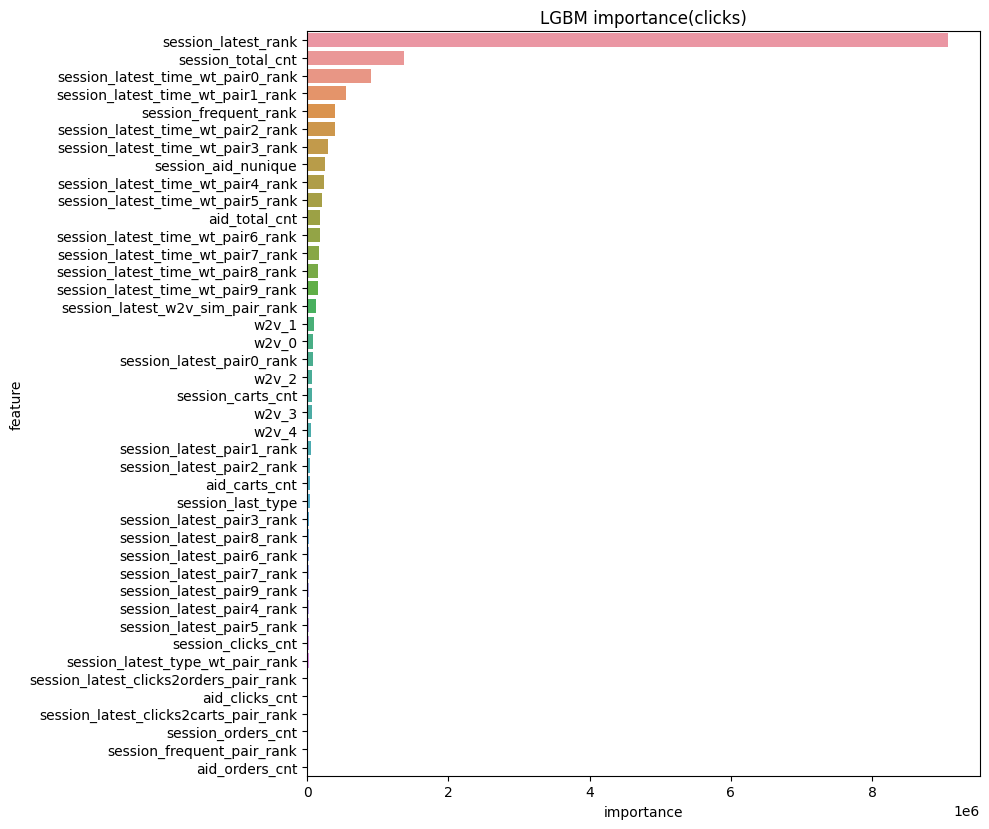

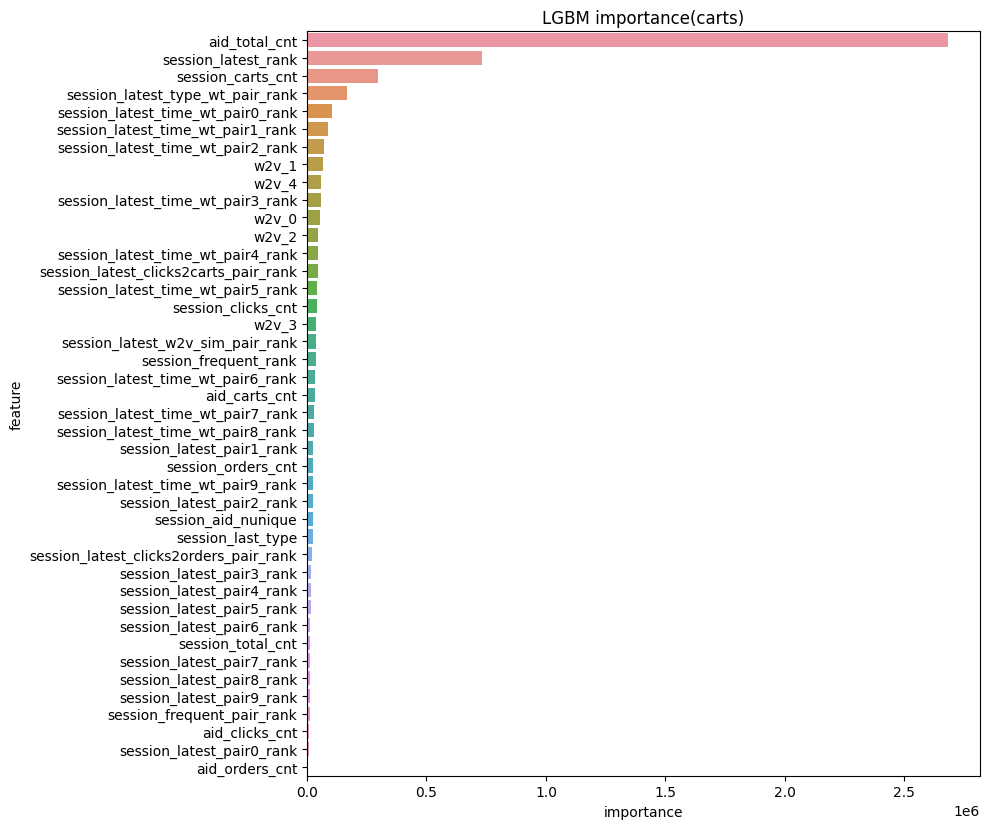

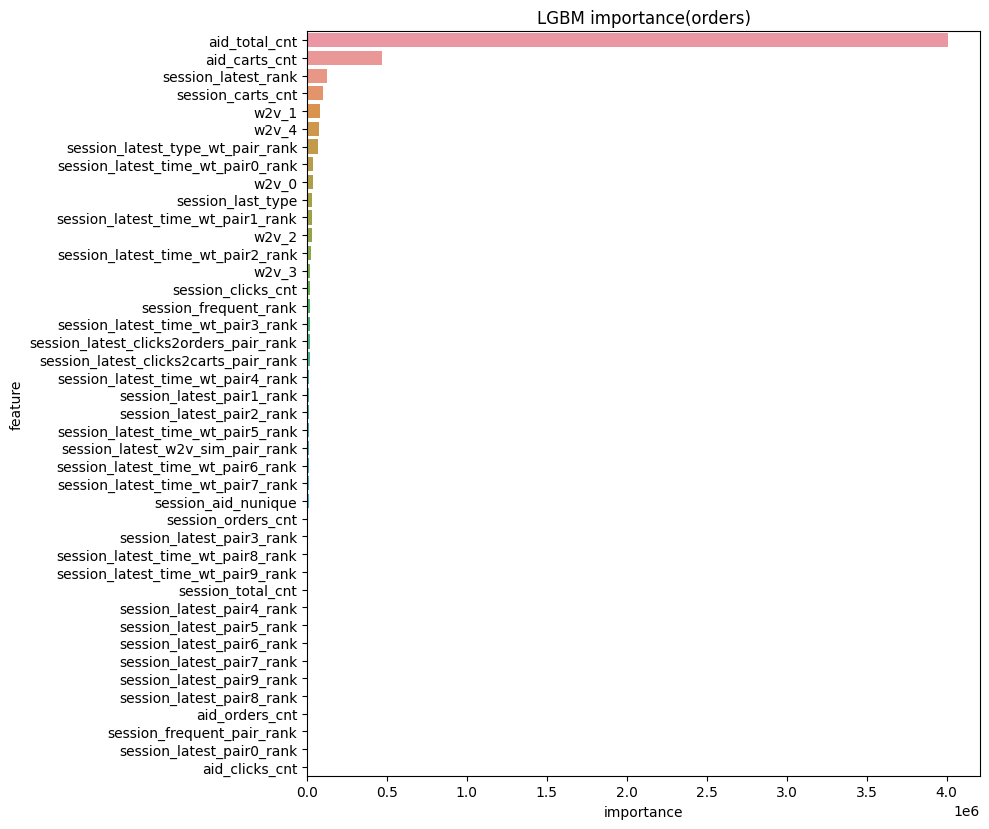

In [42]:
try:
    main()
except Exception as e:
    logger.error(traceback.format_exc())
    line_notify.send(f"{cfg.exp_name} | ERROR!!\n{traceback.format_exc()}")